#### This is a secound version of the Wally_CSV prepper. 
Couldnt get the figure out what caused the error in Edge Impulse DSP block, when uploading to ingestion service.
After trying out different formats, and just uploading normal png's, i found out in that the only way to upload fotos is as png or jpg. 
This script converts all the np arrays into PNG, with unique ID's, transfer the into 2 folders for training and testing. In the folders they will be devided into 2 sections, 50, 200 and all which is how many photos of each label there is. In these subfolders will be one folder pr label where the PNGs will be saved.

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as im

import random, os, PIL, json, time, hmac, hashlib, requests, threading, queue
import shortuuid

from skimage.transform import resize   

In [2]:
### Settings

#Folders for training and test sets:
TRAINFOLDER = "trainPNG"
TESTFOLDER = "testPNG"

# Project folder:
PROJECTDIR = "/home/kultul/Wally"

# Number of threads to run to upload data to Edge Impulse
NUM_THREADS = 20

# Number of PNG's pr sub folder and amount of subfolders. Just all more to the list if needed
F1 = 50
F2 = 200
F3 = "all"

FOLDERLIST = [F1,F2,F3]

# List for labels, we will need it later
LABELLIST = ["a","b","c","d","e","f","g","h","i","j","k","l","m","n",
             "o","p","q","r","s","t","u","v","w","x","y","z"]

In [21]:
train_df = pd.read_csv('dataset/sign_mnist_train.csv')
test_df = pd.read_csv('dataset/sign_mnist_test.csv')

In [22]:
train_df = train_df.sort_values(by='label')
test_df = test_df.sort_values(by='label')

In [23]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
5667,0,74,85,44,0,37,48,51,57,63,...,97,72,139,153,152,155,158,158,161,163
6969,0,170,171,173,176,177,180,182,183,187,...,26,2,137,244,225,229,229,230,229,228
18083,0,189,191,193,194,195,196,198,199,199,...,101,84,60,45,35,32,35,35,34,32
24418,0,158,157,156,157,158,158,158,159,159,...,201,208,207,207,207,205,203,203,202,202
15296,0,188,190,193,194,195,195,196,196,196,...,166,167,169,170,157,118,124,138,66,40


In [24]:
train_label=train_df['label']
train_label.astype(str)
trainset=train_df.drop(['label'],axis=1)
trainset.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
5667,74,85,44,0,37,48,51,57,63,69,...,97,72,139,153,152,155,158,158,161,163
6969,170,171,173,176,177,180,182,183,187,188,...,26,2,137,244,225,229,229,230,229,228
18083,189,191,193,194,195,196,198,199,199,199,...,101,84,60,45,35,32,35,35,34,32
24418,158,157,156,157,158,158,158,159,159,159,...,201,208,207,207,207,205,203,203,202,202
15296,188,190,193,194,195,195,196,196,196,197,...,166,167,169,170,157,118,124,138,66,40


In [25]:
X_train = trainset.values
X_train = trainset.values.reshape(-1,28,28)
print(X_train.shape)

(27455, 28, 28)


In [26]:
test_label=test_df['label']
X_test=test_df.drop(['label'],axis=1)
print(X_test.shape)

(7172, 784)


Text(0.5, 1.0, 'label: 13  letter: A')

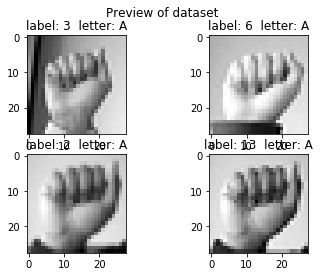

In [28]:
#View some of the training samples.
fig,axe=plt.subplots(2,2)
fig.suptitle('Preview of dataset')
axe[0,0].imshow(X_train[0].reshape(28,28),cmap='gray')
axe[0,0].set_title('label: 3  letter: A')
axe[0,1].imshow(X_train[1].reshape(28,28),cmap='gray')
axe[0,1].set_title('label: 6  letter: A')
axe[1,0].imshow(X_train[2].reshape(28,28),cmap='gray')
axe[1,0].set_title('label: 2  letter: A')
axe[1,1].imshow(X_train[4].reshape(28,28),cmap='gray')
axe[1,1].set_title('label: 13  letter: A')

In [29]:
### Convert list of samples into Numpy arrays so we can convert them into png

# Convert sets
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

# Print out the new Numpy array shapes (always a good idea to check the shapes!)
print("Training X:", X_train.shape)
print("Test X:", X_test.shape)


Training X: (27455, 28, 28)
Test X: (7172, 784)


In [30]:
def createFolders(path):
    global PROJECTDIR
    global LABELLIST
    os.chdir(PROJECTDIR)
    if (os.path.exists(path)):
        print(f"dir for {path} exists")
    else:
        os.makedirs(path)
        print(f"dir for {path} created")
    projectPath = os.path.join(PROJECTDIR, path)
    os.chdir(projectPath)
    for subFolder in FOLDERLIST:
        if (os.path.exists(subFolder)):
            print(f"dir for {subFolder} exists")
        else:
            os.makedirs(subFolder)
            print(f"dir for {subFolder} created")
        subFolderPath = os.path.join(projectPath, subFolder)
        os.chdir(subFolderPath)
        for subSubFolders in LABELLIST:
            if (os.path.exists(subSubFolders)):
                print(f"dir for {subSubFolders} exists")
            else:
                os.makedirs(subSubFolders)
                print(f"dir for {subSubFolders} created")
            os.chdir(subFolderPath)
        os.chdir(projectPath)

In [10]:
def csvToPNG(path,limit):
    global q
    global LABELLIST
    limitPath = os.path.join(path,limit)
    os.chdir(limitPath)
    while not q.empty():
        for label in LABELLIST:
            os.chdir(os.path.join(limitPath, label))
            while count < limit :
                sample, label = q.get()
                data = im.fromarray((sample*255).astype(np.uint8))
                name = f"{label}" + "." + shortuuid.ShortUUID().random(length=22) + ".png"
                data.save(name)

In [51]:
createFolders(TRAINFOLDER)
len_vector = len(X_train)

q = queue.Queue()
for i in range(len_vector):
    q.put((X_train[i], train_label[i]))

csvToPNG(TRAINFOLDER,FOLDERLIST[0])

####################################

createFolders(TESTFOLDER)
len_vector = len(X_test)

q = queue.Queue()
for i in range(len_vector):
    q.put((X_train[i], train_label[i]))

csvToPNG(TESTFOLDER)

dir for trainPNG created
